In [2]:
import h5py
import numpy as np
import pandas as pd 

import fastdtw
import scipy.spatial.distance as sd

from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from sklearn import manifold, datasets 
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt
import seaborn as sns 
plt.rcParams["figure.figsize"] = [16,9]
sns.set_style('whitegrid')

GRID_SIZE = 0.06
LOWER_LAMBDA = 6472.5
UPPER_LAMBDA = 6740
PLOT_MASK = range(1475,1550)

In [2]:
cotar_classified = pd.read_csv("/home/pravn/Dropbox/Masters/Research Data/results.csv",index_col=0)

In [3]:
unproblem_ids = pd.read_csv("/home/pravn/Dropbox/unproblem_ids.csv",index_col=0)

In [44]:
unproblem_ids["sobject_id"].count()

356299

In [4]:
df_temp = pd.merge(unproblem_ids , cotar_classified, how='outer', indicator=True, on="sobject_id")

In [5]:
df_temp["_merge"].value_counts()

left_only     353403
right_only      4081
both            2896
Name: _merge, dtype: int64

In [4]:
original_masked = pd.read_csv("/home/pravn/Documents/original_masked_ew_sobject_id_3.csv")

In [5]:
original_masked["sobject_id"].count()

588344

In [6]:
unproblem_ids = pd.read_csv("/home/pravn/Dropbox/unproblem_ids.csv",index_col=0)

In [7]:
df_temp = pd.merge(original_masked , unproblem_ids, how='outer', indicator=True, on="sobject_id")

In [8]:
df_temp["_merge"].value_counts()

both          356299
left_only     232045
right_only         0
Name: _merge, dtype: int64

In [9]:
good_ids = df_temp.loc[df_temp["_merge"]=="both"]

In [10]:
good_ids_masked = good_ids[good_ids["EW"]>0.25]

In [11]:
good_ids_masked["EW"].describe()

count    2370.000000
mean        0.443516
std         0.248136
min         0.250022
25%         0.292464
50%         0.358948
75%         0.493225
max         3.588870
Name: EW, dtype: float64

In [12]:
good_ids_masked_25_data_only = good_ids_masked.drop(columns=['EW','sobject_id','_merge'])

In [27]:
good_ids_masked_01_data_only = good_ids_masked_25_data_only

In [13]:
good_ids_masked_01_data_only_np = good_ids_masked_25_data_only.to_numpy()

In [14]:
def my_fastdtw(spec1, spec2):
    return fastdtw.fastdtw(spec1, spec2)[0]

In [15]:
distance_matrix = sd.pdist(good_ids_masked_01_data_only_np, my_fastdtw)

In [16]:
distance_matrix_square_form = sd.squareform(distance_matrix)

In [17]:
def distance_cost_plot(distances):
    im = plt.imshow(distances, interpolation='nearest', cmap='Blues') 
    plt.gca().invert_yaxis()
    plt.xlabel("Sample")
    plt.ylabel("Sample")
    plt.title("DTW Distance")
    plt.grid()
    plt.legend
    plt.colorbar();

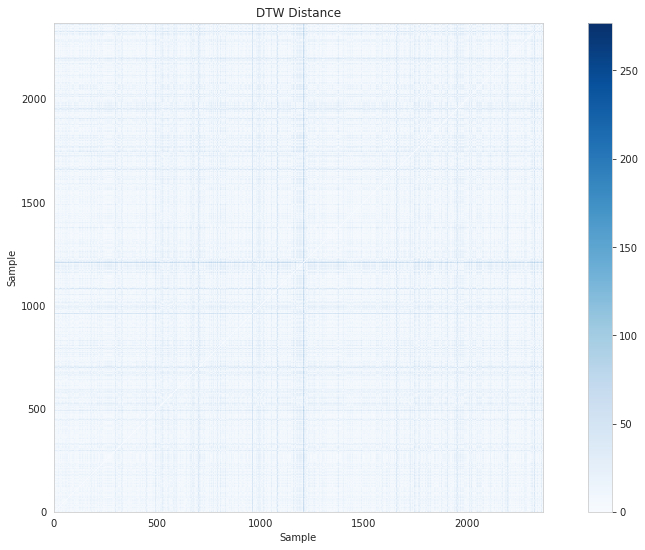

In [18]:
distance_cost_plot(distance_matrix_square_form)

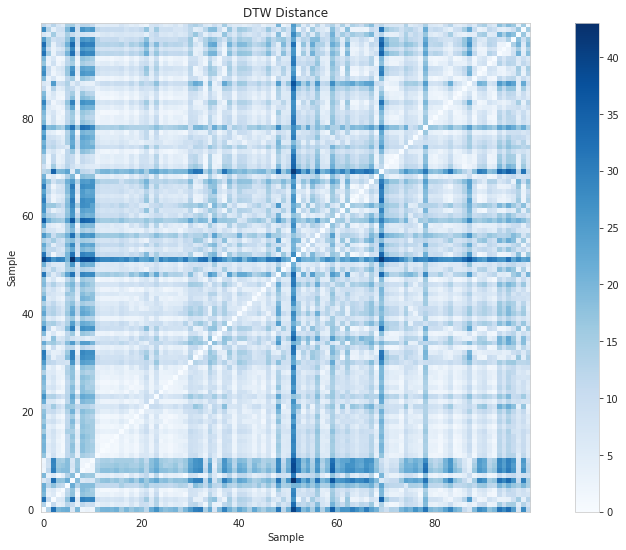

In [19]:
distance_cost_plot(distance_matrix_square_form[0:100:,0:100])

In [23]:
agglom = AgglomerativeClustering(n_clusters = 10, linkage = 'complete', affinity='precomputed')
agglom.fit(distance_matrix_square_form)
agglom.labels_

array([0, 0, 2, ..., 0, 0, 0])

In [24]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [25]:
score = silhouette_score(good_ids_masked_01_data_only_np, agglom.labels_)
print(score)

0.18319831246658014


In [28]:
old_names = good_ids_masked_01_data_only.columns.tolist()

In [29]:
hf_grid = h5py.File("/home/pravn/Dropbox/Masters/Research Data/wl_grid.h5", "r")
wl_grid = np.array(hf_grid["wl_grid"])

In [30]:
new_names = wl_grid[PLOT_MASK].tolist()

In [31]:
col_rename_dict = {i:j for i,j in zip(old_names, new_names)}

In [32]:
good_ids_masked_01_data_only.rename(columns=col_rename_dict, inplace=True)

In [33]:
good_ids_masked_01_data_only.head()

,6561.00,6561.06,6561.12,6561.18,6561.24,6561.30,6561.36,6561.42,6561.48,6561.54,...,6564.90,6564.96,6565.02,6565.08,6565.14,6565.20,6565.26,6565.32,6565.38,6565.44
631,0.990615,0.999885,1.005374,1.006351,0.980763,0.981750,0.998437,0.988112,0.986611,0.978984,...,0.983445,0.964968,0.974401,0.997825,0.991588,0.983049,0.982681,0.966851,0.977266,0.999890
1429,0.946630,0.950577,0.950637,0.944570,0.933469,0.922623,0.926082,0.948550,0.947866,0.927540,...,1.027800,1.025130,1.014040,1.014703,1.008876,0.975355,1.004783,1.019381,1.007313,0.994922
2258,0.703636,0.666405,0.663031,0.672163,0.703025,0.780854,0.846787,0.820752,0.758904,0.745143,...,0.758796,0.789579,0.823938,0.826912,0.799133,0.777822,0.772169,0.766738,0.770953,0.802112
2685,0.933116,0.933053,0.945030,0.937644,0.926131,0.920698,0.926624,0.928057,0.921674,0.915727,...,0.909760,0.907227,0.908541,0.904046,0.900437,0.907782,0.912921,0.901948,0.896790,0.909004
2724,0.934783,0.953698,0.960972,0.952328,0.962581,0.959026,0.954503,0.943006,0.931546,0.935318,...,0.952878,0.976072,0.994577,0.991366,0.973925,0.960131,0.950665,0.940484,0.933170,0.933704


In [34]:
good_ids_masked_01_data_only["label"] = pd.Series(agglom.labels_, index = good_ids_masked_01_data_only.index)

In [35]:
good_ids_masked_01_data_only["sobject_id"] = good_ids_masked["sobject_id"]

In [36]:
good_ids_masked_01_data_only["label"].value_counts()

0    1460
2     814
6      37
3      23
4      13
9      10
1       9
8       2
7       1
5       1
Name: label, dtype: int64

In [37]:
df_masked = good_ids_masked_01_data_only

Int64Index([  4701,  39609,  42264, 118924, 121084, 126776, 136767, 158972,
            174550, 174563, 174621, 174658, 322014, 322254, 322371, 346407,
            348271, 354105, 410220, 410700, 547366, 552865, 564420],
           dtype='int64')


Text(6562.78, 2.5, 'Hα')

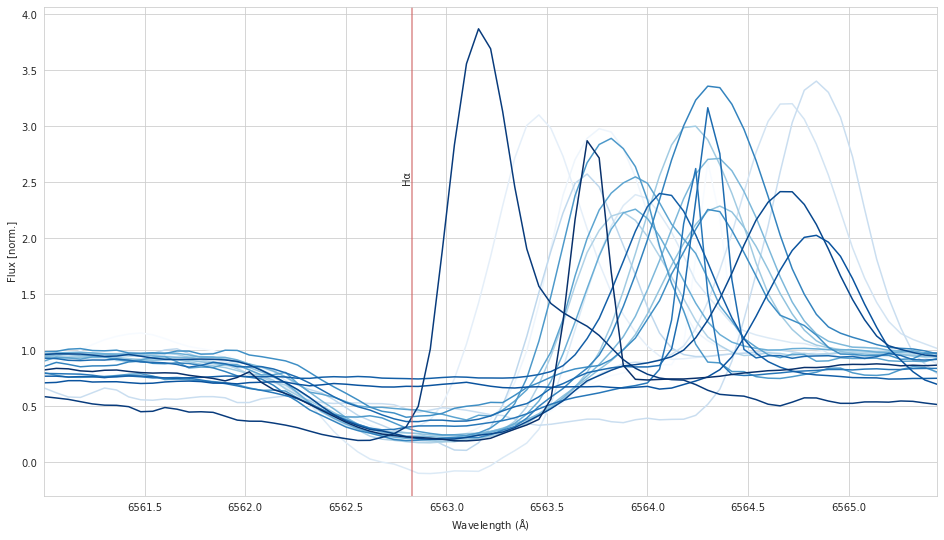

In [48]:
CLASS = 3
df_masked_label = df_masked.loc[df_masked["label"]==CLASS]
print(df_masked_label.index)
ax = (df_masked.loc[df_masked['label'] == CLASS].drop(columns=['label','sobject_id']).T).plot(
    legend=False, 
    xlabel = "Wavelength ($\mathrm{\AA}$)", 
    ylabel = "Flux [norm.]",
    #xticks = wl_grid[PLOT_MASK],
    xlim = (wl_grid[PLOT_MASK].min(),wl_grid[PLOT_MASK].max()),
    colormap = "Blues"
    )
halpha_line = ax.axvline(x=6562.83, color='indianred', label="coral", alpha=0.7)
ax.text(6562.78,2.5,"Hα", rotation=90)